<a href="https://colab.research.google.com/github/sakibchowdhury131/GAN/blob/main/GAN_Eiffel_Tower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np

import keras 
from keras.models import Sequential, Model
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D, Dense, Conv2D, BatchNormalization, Dropout, Flatten, Input
from keras.optimizers import RMSprop
 
import pandas as pd
from keras.utils import plot_model
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
input_images = "/content/drive/MyDrive/Colab Notebooks/GAN/full_numpy_bitmap_The Eiffel Tower.npy"

In [ ]:
data = np.load(input_images)

In [ ]:
data = data / 255
data = np.reshape(data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]

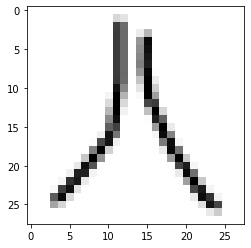

In [ ]:
plt.imshow(data[4343, :, :, 0], cmap = 'Greys')

In [ ]:
def discriminator_builder(width = 64, p = 0.4):
  #define the inputs
  inputs = Input((img_w, img_h, 1))
 
  #convolution layers
  conv1 = Conv2D(width*1, 5, strides=2, padding= 'same', activation= 'relu')(inputs)
  conv1 = Dropout(p)(conv1)
  
  conv2 = Conv2D(width*2, 5, strides=2, padding= 'same', activation= 'relu')(conv1)
  conv2 = Dropout(p)(conv2)
  
  conv3 = Conv2D(width*4, 5, strides=2, padding= 'same', activation= 'relu')(conv2)
  conv3 = Dropout(p)(conv3)
 
  conv4 = Conv2D(width*8, 5, strides=1, padding= 'same', activation= 'relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))
 
  #output layer
  output = Dense(1, activation= 'sigmoid')(conv4)
 
  #model definition
  model = Model(inputs = inputs, outputs = output)
  model.summary()
  
 
 
  return model

In [ ]:
discriminator = discriminator_builder()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

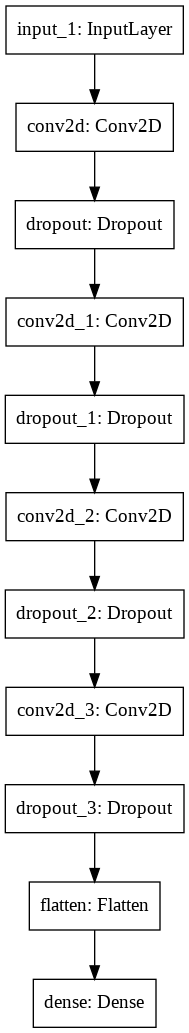

In [ ]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer= RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                      metrics=['accuracy'])
plot_model(discriminator)

In [ ]:
def generator_builder(z_dim = 100, width=64, p=0.4):
  #define the inputs
  inputs = Input((z_dim,))
 
  #first dense layer:
  dense1 = Dense(7*7*64)(inputs)
  dense1 = BatchNormalization(momentum=0.9)(dense1)
  dense1 = Activation(activation = 'relu')(dense1)
  dense1 = Reshape((7,7,64))(dense1)
  dense1 = Dropout(p)(dense1)
 
  #deconvolution layers
  conv1 = UpSampling2D()(dense1)
  conv1 = Conv2DTranspose(int(width/2), kernel_size = 5, padding = 'same', activation=None)(conv1)
  conv1 = BatchNormalization(momentum= 0.9)(conv1)
  conv1 = Activation(activation = 'relu')(conv1)
 
  conv2 = UpSampling2D()(conv1)
  conv2 = Conv2DTranspose(int(width/4), kernel_size = 5, padding = 'same', activation=None)(conv2)
  conv2 = BatchNormalization(momentum= 0.9)(conv2)
  conv2 = Activation(activation = 'relu')(conv2)
 
  conv3 = Conv2DTranspose(int(width/8), kernel_size = 5, padding = 'same', activation=None)(conv2)
  conv3 = BatchNormalization(momentum= 0.9)(conv3)
  conv3 = Activation(activation = 'relu')(conv3)
 
  #output layer
  output = Conv2D(1, kernel_size = 5, padding = 'same', activation = 'sigmoid')(conv3)
 
  #defining model 
  model = Model(inputs = inputs, outputs = output)
  model.summary()
  plot_model(model)
  return model

In [ ]:
generator = generator_builder()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_4 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 64)        0   

In [ ]:
def adversarial_builder(z_dim = 100):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
 
  model.compile(loss = 'binary_crossentropy',
                optimizer = RMSprop(lr = 0.0004, decay = 3e-8, clipvalue = 1.0),
                metrics = ['accuracy'])
  
  model.summary()
  plot_model(model)
 
  return model

In [ ]:
adversarial_model = adversarial_builder()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 28, 28, 1)         396961    
_________________________________________________________________
model_2 (Functional)         (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [ ]:
def make_trainable(net, val):
  net.trainable = val
  for l in net.layers:
    l.trainable = val

In [ ]:

def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
100
200
300
400
Epoch #500
499: [D loss: 0.413779, acc: 0.820586]  [A loss: 2.290963, acc: 0.143255]


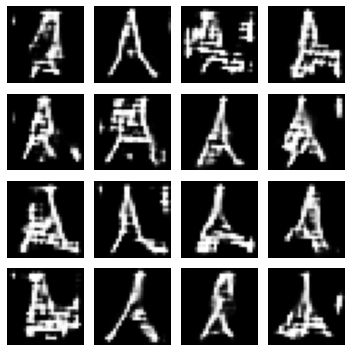

500
600
700
800
900
Epoch #1000
999: [D loss: 0.516806, acc: 0.751908]  [A loss: 1.906125, acc: 0.116820]


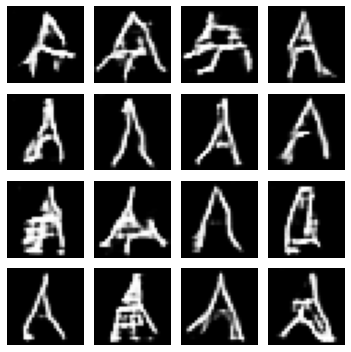

In [ ]:
a_metrics_complete, d_metrics = train(epochs = 1000)